# ocaml-alloc-stats lifetimes

This notebook allows you to read a ".ctf" common trace format file containing a memtrace trace
of allocations from which you can plot some histograms, and perform some simple statistical analysis.

Sample ctf files are uploaded to a shared google drive folder here: https://drive.google.com/drive/folders/1ce5LJ7vEgnaPVgtgUeJ23jHG9vp4K50k?usp=share_link

In the cell below you can specify the ctf file you wish to work with. The file `irmin-replay.ctf` should be present in the git repo and serves as a good example.


In [41]:
ctf_file = "irmin-replay.ctf"

# The following flag controls whether we discard allocations that don't survive the minor 
# heap. These allocations are almost free, so it usually makes sense to discard them when
# focusing on the behaviour of the major heap allocator. FIXME TODO
ignore_minor_only_allocations = True

debug=False # include debug output?

Check that the ctf and executables are present.

In [42]:
# from https://data36.com/plot-histogram-python-pandas/
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import csv # reading CSV format trace files
import subprocess # for calling ocaml executables
import math 
import os.path
import json
import collections


# check that a file we rely on is present
def file_exists(name):
    return os.path.exists(name)

dump_exe = "./dump_trace.exe"

assert file_exists(dump_exe)
assert file_exists(ctf_file)
print("OK, files are present:", dump_exe, ctf_file)

OK, files are present: ./dump_trace.exe irmin-replay.ctf


Run the executable, store results in a temporary file, and return the name of the temporary file. An alternative would be to read the .ctf directly in Python, but according to 
https://babeltrace.org/docs/v2.0/python/bt2/ the Python API is undocumented (although 
probably not too hard to figure out if the current approach is deemed too ugly).

In [43]:
def convert_ctf_to_dump(filename):
    # translate to lookahead format
    outfile1 = filename+".dump"
    subprocess.run([dump_exe,ctf_file,outfile1],check=True)
    return outfile1

the_ctf_dump = convert_ctf_to_dump(ctf_file)

print("NOTE converted ctf placed in file "+the_ctf_dump)

NOTE converted ctf placed in file irmin-replay.ctf.dump


In [54]:
# now we can read the dumped file as plain csv

if ignore_minor_only_allocations: 
    if debug: print("NOTE we are ignoring minor-only allocations")
else: 
    if debug: print("NOTE we are including minor-only allocations")

# read dump, retain all info, return as list
def read_dump(fn):
    xs = []
    with open(fn) as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        for row in reader:
            id = row[1]
            entry_type = row[2]
            assert (entry_type in ["A","a","AE","P","C"])
            entry = {}
            if entry_type in ["A","a","AE"]:
                sz = int(row[3])
                time = int(row[0])
                entry={'id':id,'type':entry_type,'sz':sz,'time':time}
            else: entry={'id':id,'type':entry_type,'time':time}
            xs.append(entry)
    return xs

the_raw_trace = read_dump(the_ctf_dump)
# print(the_raw_trace[0:10])

assert ignore_minor_only_allocations

# remove allocs that never make it out of the minor heap (they are mostly noise); 
# remove promotes; keep collects for major allocs
def remove_minor_allocs(trace):
    res = [] # result trace
    in_minor = {} # dict of (id -> size) of allocs currently in the minor heap
    for x in trace:
        id = x['id']
        if x['type'] == "a":
            in_minor[id] = x['sz']
        if x['type'] == "A" or x['type'] == "AE":
            res.append(x)
        if x['type'] == "C":
            if id in in_minor.keys(): pass # drop event
            else: res.append(x) # otherwise add to result                
        if x['type'] == "P":
            sz = in_minor[id]
            # convert to a major alloc at time of promote            
            del in_minor[id]
            # NOTE in the following the time is taken to be the time of the promote event
            res.append({'id':id,'type':"A",'sz':sz,'time':x['time']})
    return res
        
the_trace = remove_minor_allocs(the_raw_trace)

# at this point we have alloc and collect events; we can use this to examine lifetimes

# print(the_trace[0:10])
print("Read",len(the_trace),"events")

Read 1477 events


In [55]:
# NOTE the time here is not wall time; instead each alloc event constitutes a clock tick
def lifetimes(trace):
    alloc_time = {} # map id to index in trace at which the alloc occurred
    lifetimes = {} # when we see a collect event, record id -> lifetime 
    time = 0
    for x in trace:
        time = time + 1
        ty = x['type']
        id = x['id']
        assert ty == "A" or ty == "AE" or ty == "C"
        if ty == "A" or ty == "AE":
            alloc_time[id] = time
        elif ty == "C":
            lifetimes[id] = time - alloc_time[id]
            del alloc_time[id]
    # the remaining entries in alloc_time survived to end of run
    print("Number of allocs that survived to end of run:",len(alloc_time))
    time = time + 1
    for id in alloc_time.keys():
        lifetimes[id] = time - alloc_time[id]
    return lifetimes

the_lifetimes = lifetimes(the_trace)
xs = sorted(the_lifetimes.items())
ys = list(map(lambda x: x[1], xs))
print("Max lifetime:", max(ys))
if debug: ys

Number of allocs that survived to end of run: 1
Max lifetime: 467


In [56]:
if debug: the_trace

(array([ 0., 56., 83., 54., 20., 18., 29., 16.,  6., 17., 19., 23., 12.,
        28., 14., 24., 26., 19., 31., 29.,  6., 26., 22.,  7.,  4.,  5.,
         9.,  4.,  6.,  6.,  5., 12.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32.]),
 <BarContainer object of 32 artists>)

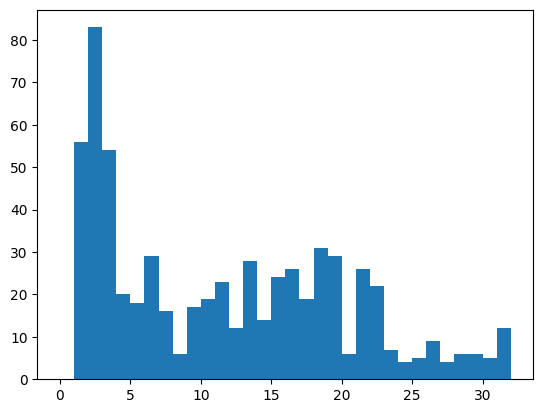

In [57]:
plt.hist(np.array(ys),range=(0,32),bins=32) 

In [62]:
# lifetimes based on timestamps
def lifetimes_ts(trace):
    alloc_time = {} # map id to time alloc occurred
    lifetimes = {} # when we see a collect event, record id -> lifetime 
    for x in trace:
        ty = x['type']
        id = x['id']
        assert ty == "A" or ty == "AE" or ty == "C"
        if ty == "A" or ty == "AE":
            alloc_time[id] = x['time']
        elif ty == "C":
            lifetimes[id] = x['time'] - alloc_time[id]
            del alloc_time[id]
    # the remaining entries in alloc_time survived to end of run
    print("Number of allocs that survived to end of run:",len(alloc_time))
    max_time = max(map(lambda x: x['time'],trace))
    for id in alloc_time.keys():
        lifetimes[id] = max_time - alloc_time[id]
    return lifetimes

the_lifetimes_ts = lifetimes_ts(the_trace)

xs = sorted(the_lifetimes_ts.items())
ys = list(map(lambda x: x[1], xs))
print("Max lifetime:", max(ys))
if debug: ys

Number of allocs that survived to end of run: 1
Max lifetime: 13745183


(array([251.,  85., 108.,  84.,  77.,  24.,  14.,   9.,   9.,   4.,   2.,
          4.,   4.,   2.,   3.,  14.,   3.,   3.,   6.,   4.,   6.,   1.,
          4.,   2.,   3.,   1.,   2.,   2.,   2.,   0.,   0.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([       0.  ,   137451.83,   274903.66,   412355.49,   549807.32,
          687259.15,   824710.98,   962162.81,  1099614.64,  1237066.47,
         1374518.3 ,  1511970.13,  1649421.96,  1786873.79,  1924325.62,
         2061777.45,  2199229.28,  2336681.11,  2474132.94,  2611584.77,
         2749036.6 ,  2886

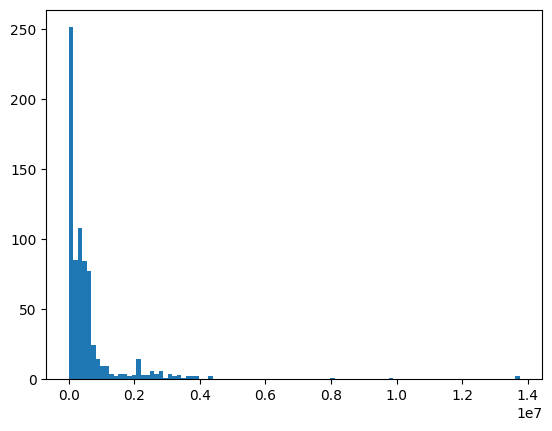

In [66]:
plt.hist(np.array(ys),bins=100) 